In [1]:
# needs libraries: DataFrames, CSV, BlackBoxOptim, Plots, Statistics, Test, BenchmarkTools
include("../src/Hydro.jl");

In [2]:
using .Hydro
using CSV
using DataFrames
using Printf: @sprintf

# Load some data

In [3]:
# load a test dataset from a CSV file into a dataframe
df = CSV.read("../test/data/test_2_data.csv", header=1, missingstrings=["-9999"]);

In [4]:
size(df)

(12417, 5)

In [5]:
len = @sprintf("%.1f", size(df)[1] / 365)
println("Period of record is $len years")

Period of record is 34.0 years


In [6]:
names(df)

5-element Array{Symbol,1}:
 :date            
 :obs_rain        
 :obs_pet         
 :obs_runoff      
 :obs_runoff_sim_0

In [7]:
# rename the columns
names!(df, Symbol.(["date", "obs_rain", "obs_pet", "obs_runoff", "test_sim_runoff"]));

In [8]:
# Create a dictionary of data from the dataframe - standard data structure through Hydro
data = Dict()
data[:rain] = df[:obs_rain]
data[:pet] = df[:obs_pet]
data[:runoff_obs] = df[:obs_runoff]
data[:runoff_sim_test] = df[:test_sim_runoff];

# Calibrate GR4J parameters

- GR4J model with NSE objective function (minimised so -ve)
- Differential evolution optimiser with adaptive weights over a limited radius
- Take best parameter set after 5 minutes
- Display best sample every 15 seconds

Available methods: https://github.com/robertfeldt/BlackBoxOptim.jl#existing-optimizers

In [9]:
# build up dictionary of model functions needed for calibration
functions = Dict()
functions[:run_model_time_step] = gr4j_run_step
functions[:init_state] = gr4j_init_state
functions[:params_from_array] = gr4j_params_from_array
functions[:objective_function] = (obs, sim) -> -1 * nse(obs, sim)
functions[:params_inverse_transform] = gr4j_params_trans_inv
functions[:params_range_transform] = gr4j_params_range_trans
functions[:params_range_to_tuples] = gr4j_params_range_to_tuples

gr4j_params_range_to_tuples (generic function with 1 method)

In [10]:
# build up dictionary of optimiser options needed for calibration
opt_options = Dict()
opt_options[:max_iterations] = false
opt_options[:max_time] = 5 * 60
opt_options[:trace_interval] = 15
opt_options[:method] = :adaptive_de_rand_1_bin_radiuslimited

:adaptive_de_rand_1_bin_radiuslimited

In [11]:
opt_pars, opt_nse = calibrate(functions, opt_options, data, gr4j_params_range())
opt_nse *= -1

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64},BlackBoxOptim.RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},BlackBoxOptim.RandomBound{BlackBoxOptim.RangePerDimSearchSpace}}
0.00 secs, 0 evals, 0 steps
15.08 secs, 35 evals, 18 steps, improv/step: 0.500 (last = 0.5000), fitness=-0.532241052
30.22 secs, 78 evals, 42 steps, improv/step: 0.524 (last = 0.5417), fitness=-0.603242016
45.41 secs, 128 evals, 78 steps, improv/step: 0.462 (last = 0.3889), fitness=-0.668107646
60.43 secs, 169 evals, 108 steps, improv/step: 0.463 (last = 0.4667), fitness=-0.668107646
75.82 secs, 220 evals, 145 steps, improv/step: 0.414 (last = 0.2703), fitness=-0.668107646
90.88 secs, 267 evals, 182 steps, improv/step: 0.390 (last = 0.2973), fitness=-0.668107646
106.16 secs, 322 evals, 223 steps, improv/step: 0.381 (last = 0.3415), fitness=-0.668107646
121.39 secs, 376 evals, 270 steps, improv/step: 0.370 (last = 0.3191), fitness=-0.683904250
136.46 

0.8096411696394267

In [12]:
opt_pars

Dict{Symbol,Float64} with 4 entries:
  :x2 => 3.58742
  :x3 => 306.963
  :x4 => 1.34153
  :x1 => 33.0243

In [13]:
# test parameters were
gr4j_params_from_array(CSV.read("../test/data/test_2_params.csv", delim=":", header=0)[2])

Dict{Symbol,Float64} with 4 entries:
  :x2 => -0.039867
  :x3 => 249.783
  :x4 => 1.49495
  :x1 => 55.0616

# Simulate using these calibrated parameters

In [14]:
init_state = gr4j_init_state(opt_pars)

Dict{Symbol,Any} with 6 entries:
  :uh2_ordinates    => [0.239867, 0.667639, 0.0924938, 0.0]
  :uh1_ordinates    => [0.479734, 0.520266]
  :uh2              => [0.0, 0.0, 0.0, 0.0]
  :production_store => 0
  :routing_store    => 0
  :uh1              => [0.0, 0.0]

In [15]:
sim = simulate(gr4j_run_step, data, opt_pars, init_state);
data[:runoff_sim_gr4j] = sim;

In [16]:
keys(data)

Base.KeySet for a Dict{Any,Any} with 5 entries. Keys:
  :rain
  :pet
  :runoff_obs
  :runoff_sim_test
  :runoff_sim_gr4j

# Do same for simple OSTP educational model
One store and two parameters

Just search for 1 minute, searching for longer wont find a magic parameter set that makes this a good model!

In [17]:
# build up dictionary of model functions needed for calibration
functions = Dict()
functions[:run_model_time_step] = ostp_run_step
functions[:init_state] = ostp_init_state
functions[:params_from_array] = ostp_params_from_array
functions[:objective_function] = (obs, sim) -> -1 * nse(obs, sim)
functions[:params_range_to_tuples] = ostp_params_range_to_tuples

# build up dictionary of optimiser options needed for calibration
opt_options = Dict()
opt_options[:max_iterations] = false
opt_options[:max_time] = 1 * 60
opt_options[:trace_interval] = 15
opt_options[:method] = :adaptive_de_rand_1_bin_radiuslimited

opt_pars, opt_nse = calibrate(functions, opt_options, data, ostp_params_range())
opt_nse *= -1

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64},BlackBoxOptim.RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},BlackBoxOptim.RandomBound{BlackBoxOptim.RangePerDimSearchSpace}}
0.00 secs, 0 evals, 0 steps
15.01 secs, 1143 evals, 1039 steps, improv/step: 0.381 (last = 0.3811), fitness=-0.285479612
30.02 secs, 2111 evals, 2007 steps, improv/step: 0.338 (last = 0.2913), fitness=-0.286316752
45.03 secs, 3108 evals, 3004 steps, improv/step: 0.319 (last = 0.2808), fitness=-0.286334988

Optimization stopped after 4167 steps and 60.00872302055359 seconds
Termination reason: Max time (60.0 s) reached
Steps per second = 69.43990457141973
Function evals per second = 71.17298594301265
Improvements/step = Inf
Total function evaluations = 4271


Best candidate found: [17.7228, 20.4871]

Fitness: -0.286334992



0.28633499171972576

In [18]:
opt_pars

Dict{Symbol,Float64} with 2 entries:
  :loss     => 20.4871
  :capacity => 17.7228

In [19]:
init_state = ostp_init_state(opt_pars)

8.861379278667071

In [20]:
sim = simulate(ostp_run_step, data, opt_pars, init_state);
data[:runoff_sim] = sim;

# Plot a hydrograph for a few months

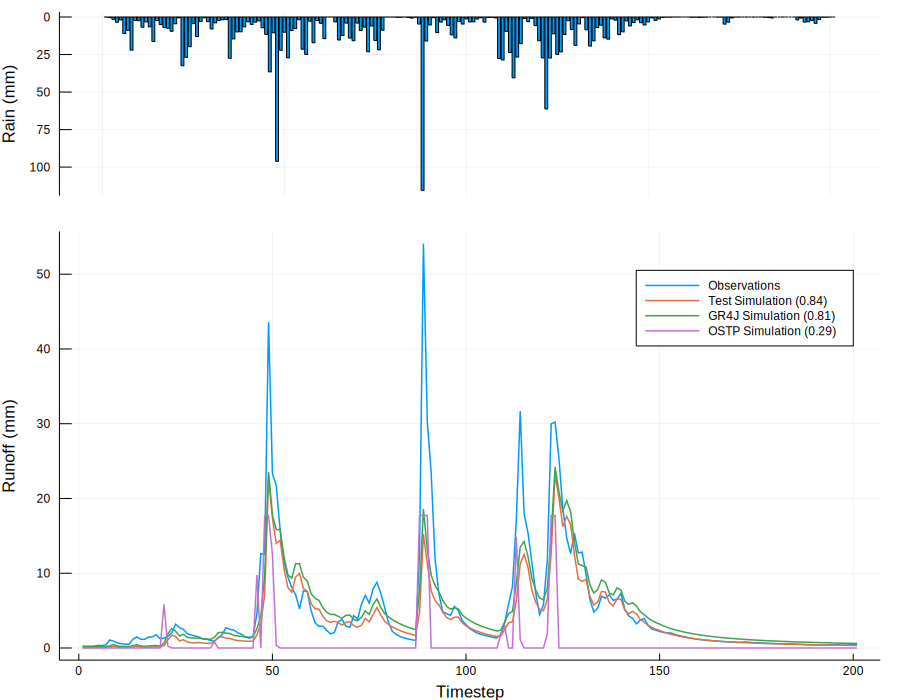

In [21]:
s, e = 12000, 12200

obs = data[:runoff_obs][s:e]
test = data[:runoff_sim_test][s:e]
gr4j = data[:runoff_sim_gr4j][s:e]
ostp = data[:runoff_sim][s:e]
rain = data[:rain][s:e]

nse_test = @sprintf("%.2f", nse(data[:runoff_obs], data[:runoff_sim_test]))
nse_gr4j = @sprintf("%.2f", nse(data[:runoff_obs], data[:runoff_sim_gr4j]))
nse_ostp = @sprintf("%.2f", nse(data[:runoff_obs], data[:runoff_sim]))

hydrograph(rain, [obs, test, gr4j, ostp], 
    ["Observations", "Test Simulation ($nse_test)", "GR4J Simulation ($nse_gr4j)", "OSTP Simulation ($nse_ostp)"])